# Introduction to the Dataset

Valeriano, B., & Maness, R. C. (2014). The dynamics of cyber conflict between rival antagonists, 2001–11. Journal of Peace Research, 51(3), 347–360. http://www.jstor.org/stable/24557484

Each pair of states engaged in cyber conflict has two states involved.
Dataset: https://drryanmaness.wixsite.com/cyberconflict/cyber-conflict-dataset

- States: A, B
- Cyber incidents: A (initiator) -> B (target)
- Dyadic dataset: A <-> B

For individual cyber conflicts, the dataset uses the concept of ‘cyber incident.’ Incidents may include thousands of events, but accounting for every single intrusion or attack made is impossible. In this case, the issue is how to count campaigns such as the SolarWinds intrusion? Should the Russian intrusion into SolarWinds be coded as a single campaign, an active intrusion into 110 organizations or a latent intrusion into 10,000? In the CDID data set, SolarWinds is counted as one incident.

In addition, it is difficult to identify the perpetrator (attribution) in cyberspace. Therefore we also have to add a caveat to the initiator and target for each incident in the dataset.

Codebook: https://a678132e-4067-4ed4-800a-239c80659fd1.filesusr.com/ugd/4b99a4_ca35bdb6bd55443e890d2dab86910b4c.pdf

# Libraries Used

- pandas
- matplotlib
- networkx
- pyvis

In [43]:
import pandas as pd

In [44]:
# Load the dataset
file_path = 'data/DCID_2.0_Release_update_February_2023.xlsx'
# Read file from excel
dcid = pd.read_excel(file_path, "DCID_2.0_Release_update_Februar")

# Avoid duplicates on the Cyberincidentnum 
# FIXME: THIS IS STRANGE but if have to do it if working with this sheet from Excel
dcid = dcid.drop_duplicates(subset='Cyberincidentnum', keep='first')

print(dcid)

     Cyberincidentnum  Dyadpair StateA    StateB  \
0                   1      2365     US    Russia   
2                   2      2365     US    Russia   
4                   3      2365     US    Russia   
6                   4      2365     US    Russia   
8                   5      2365     US    Russia   
..                ...       ...    ...       ...   
852               427    750770  India  Pakistan   
854               428    750770  India  Pakistan   
856               429    750770  India  Pakistan   
858               430    750770  India  Pakistan   
860               431    750770  India  Pakistan   

                                   Name interactionstartdate  method  \
0                Regin malware campaign  2008-02-01 00:00:00     3.0   
2                  QWERTY keystroke log  2008-02-01 00:14:24     4.4   
4                         Duke Series_A  2008-04-08 00:14:24     4.2   
6    US govt employee in Georgia hacked  2008-08-06 00:00:00     4.2   
8              

In [45]:
# Convert the correlates of war (COW) country codes in to dcid to ISO codes
cow_countries = pd.read_csv('data/COW-country-codes.csv')
print(cow_countries)

# check for duplicates in correlates of war country codes
# AAARRHHH What!!! there are duplicates in the correlates of war country codes. Why??
cow_countries = cow_countries.drop_duplicates(subset='CCode', keep='first')
print(cow_countries)

    StateAbb  CCode                        StateNme
0        USA      2        United States of America
1        CAN     20                          Canada
2        BHM     31                         Bahamas
3        CUB     40                            Cuba
4        CUB     40                            Cuba
..       ...    ...                             ...
238      NAU    970                           Nauru
239      MSI    983                Marshall Islands
240      PAL    986                           Palau
241      FSM    987  Federated States of Micronesia
242      WSM    990                           Samoa

[243 rows x 3 columns]
    StateAbb  CCode                        StateNme
0        USA      2        United States of America
1        CAN     20                          Canada
2        BHM     31                         Bahamas
3        CUB     40                            Cuba
5        HAI     41                           Haiti
..       ...    ...                     

In [46]:
dcid = dcid.merge(cow_countries, left_on='initiator', right_on='CCode', how='left', suffixes=('', '_y'))

# Replace the target column with a country code from a correlates of war country codes
dcid = dcid.merge(cow_countries, left_on='target', right_on='CCode', how='left', suffixes=('', '_y'))

# Rename the columns StateAbb to initiator_iso
dcid = dcid.rename(columns={'StateAbb': 'initiator_iso'})
dcid = dcid.rename(columns={'StateAbb_y': 'target_iso'})

print(len(dcid))
print(dcid)
# save the file
# dcid.to_csv('export.csv', index=False)

dcid_short = dcid[['initiator_iso', 'target_iso']]
# print(dcid_short)

431
     Cyberincidentnum  Dyadpair StateA    StateB  \
0                   1      2365     US    Russia   
1                   2      2365     US    Russia   
2                   3      2365     US    Russia   
3                   4      2365     US    Russia   
4                   5      2365     US    Russia   
..                ...       ...    ...       ...   
426               427    750770  India  Pakistan   
427               428    750770  India  Pakistan   
428               429    750770  India  Pakistan   
429               430    750770  India  Pakistan   
430               431    750770  India  Pakistan   

                                   Name interactionstartdate  method  \
0                Regin malware campaign  2008-02-01 00:00:00     3.0   
1                  QWERTY keystroke log  2008-02-01 00:14:24     4.4   
2                         Duke Series_A  2008-04-08 00:14:24     4.2   
3    US govt employee in Georgia hacked  2008-08-06 00:00:00     4.2   
4          

In [47]:
# Create the adjacency matrix for dcid

ct = pd.crosstab(dcid_short['initiator_iso'], dcid_short['target_iso'])
idx = ct.columns.union(ct.index)
adjacency_matrix = ct.reindex(index = idx, columns=idx, fill_value=0)

print(adjacency_matrix)

# Save the adjacency matrix to a csv file
adjacency_matrix.to_csv('adjacency_matrix.csv', index=True)

     AFG  AUL  BAH  CAN  CHN  DRV  EST  FRN  GMY  GRG  ...  ROK  RUS  SAU  \
AFG    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
AUL    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
BAH    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
CAN    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
CHN    0    3    0    0    0    8    0    0    0    0  ...    0    0    0   
DRV    0    0    0    0    1    1    0    0    0    0  ...    0    0    0   
EST    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
FRN    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
GMY    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
GRG    0    0    0    0    0    0    0    0    0    0  ...    0    1    0   
IND    0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
IRN    0    0    3    0    0    0    0    0    0    0  ...    0    0   12   

In [48]:
# Check if the matrix is symmetric
import numpy as np
if np.array_equal(adjacency_matrix, adjacency_matrix.T):
    print('Matrix is symmetric')
else:
    print('Matrix is not symmetric')

# Save the adjacency matrix to a csv file
adjacency_matrix.to_csv('adjacency_matrix.csv') 

Matrix is not symmetric


In [49]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph(adjacency_matrix)
print(G.edges(data=True))


[('CHN', 'AUL', {'weight': 3}), ('CHN', 'DRV', {'weight': 8}), ('CHN', 'IND', {'weight': 11}), ('CHN', 'JPN', {'weight': 13}), ('CHN', 'PHI', {'weight': 8}), ('CHN', 'SIN', {'weight': 1}), ('CHN', 'TAW', {'weight': 12}), ('CHN', 'UKG', {'weight': 1}), ('CHN', 'USA', {'weight': 59}), ('DRV', 'DRV', {'weight': 1}), ('DRV', 'CHN', {'weight': 1}), ('GRG', 'RUS', {'weight': 1}), ('IND', 'PAK', {'weight': 8}), ('IRN', 'BAH', {'weight': 3}), ('IRN', 'ISR', {'weight': 20}), ('IRN', 'SAU', {'weight': 12}), ('IRN', 'TUR', {'weight': 7}), ('IRN', 'USA', {'weight': 21}), ('ISR', 'ISR', {'weight': 1}), ('ISR', 'IRN', {'weight': 7}), ('ISR', 'LEB', {'weight': 1}), ('ISR', 'SYR', {'weight': 1}), ('JPN', 'ROK', {'weight': 3}), ('PAK', 'AFG', {'weight': 1}), ('PAK', 'IND', {'weight': 18}), ('PRK', 'CHN', {'weight': 1}), ('PRK', 'FRN', {'weight': 1}), ('PRK', 'JPN', {'weight': 2}), ('PRK', 'ROK', {'weight': 35}), ('PRK', 'UKG', {'weight': 2}), ('PRK', 'USA', {'weight': 17}), ('ROK', 'JPN', {'weight': 5}

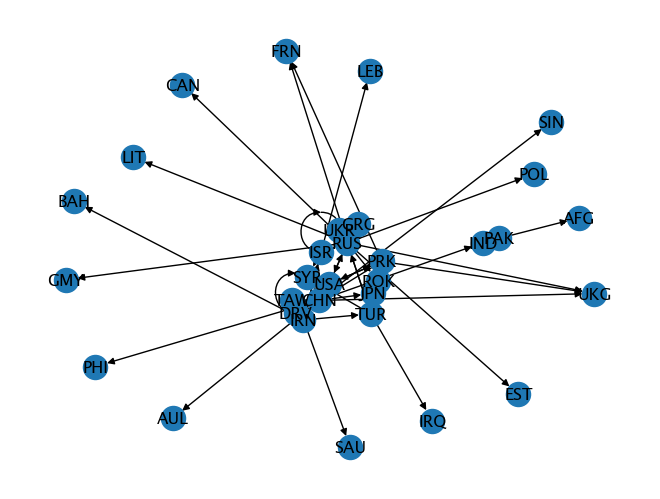

In [50]:
# Draw G graph including labels and weights
nx.draw(G, with_labels=True)


[('CHN', 'DRV', {'weight': 8}), ('CHN', 'IND', {'weight': 11}), ('CHN', 'JPN', {'weight': 13}), ('CHN', 'TAW', {'weight': 12}), ('CHN', 'USA', {'weight': 59}), ('DRV', 'DRV', {'weight': 1}), ('DRV', 'CHN', {'weight': 1}), ('GRG', 'RUS', {'weight': 1}), ('IND', 'PAK', {'weight': 8}), ('IRN', 'ISR', {'weight': 20}), ('IRN', 'TUR', {'weight': 7}), ('IRN', 'USA', {'weight': 21}), ('ISR', 'ISR', {'weight': 1}), ('ISR', 'IRN', {'weight': 7}), ('ISR', 'SYR', {'weight': 1}), ('JPN', 'ROK', {'weight': 3}), ('PAK', 'IND', {'weight': 18}), ('PRK', 'CHN', {'weight': 1}), ('PRK', 'JPN', {'weight': 2}), ('PRK', 'ROK', {'weight': 35}), ('PRK', 'USA', {'weight': 17}), ('ROK', 'JPN', {'weight': 5}), ('ROK', 'PRK', {'weight': 2}), ('RUS', 'GRG', {'weight': 8}), ('RUS', 'ROK', {'weight': 1}), ('RUS', 'TUR', {'weight': 2}), ('RUS', 'UKR', {'weight': 28}), ('RUS', 'USA', {'weight': 40}), ('SYR', 'USA', {'weight': 1}), ('TAW', 'CHN', {'weight': 1}), ('TUR', 'RUS', {'weight': 2}), ('TUR', 'SYR', {'weight': 1

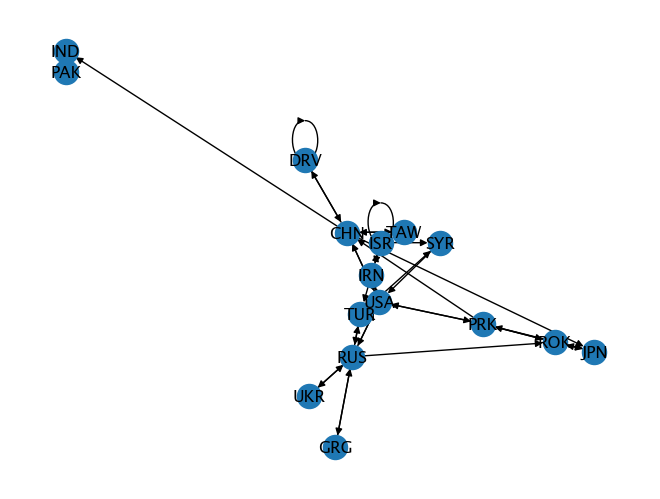

In [51]:
# Keep only nodes with outdegree > 0
# The node out_degree is the number of edges pointing out of the node
# The ones initiating the attack
outdeg = G.out_degree()

G2 = G.copy()
for node in G.nodes():
    if outdeg[node] == 0:
        G2.remove_node(node)

print(G2.edges(data=True))
nx.draw(G2, with_labels=True)

# Now we can see that some connections are only one way: e.g. 
# 365 Russia -> 732 (South Korea)
# FIXME: not every time I create the graph! WHY IS THIS RANDOM?

{('CHN', 'AUL'): Text(0.37840387602683, 0.2782020691840974, '3'),
 ('CHN', 'DRV'): Text(0.17918194394461628, -0.1209614179425329, '8'),
 ('CHN', 'IND'): Text(0.16472365405862477, -0.392634047544123, '11'),
 ('CHN', 'JPN'): Text(-0.08278559416816278, -0.12827703852523342, '13'),
 ('CHN', 'PHI'): Text(0.5367310574641513, -0.1928396843431055, '8'),
 ('CHN', 'SIN'): Text(-0.4178436035559232, -0.22519973960159834, '1'),
 ('CHN', 'TAW'): Text(0.15760224933294564, -0.17948572200729807, '12'),
 ('CHN', 'UKG'): Text(-0.19568362488325342, -0.4768963704650091, '1'),
 ('CHN', 'USA'): Text(0.04305161342067376, 0.00031063746626447397, '59'),
 ('DRV', 'DRV'): Text(0.2266720510444542, 0.06432128923855651, '1'),
 ('DRV', 'CHN'): Text(0.17919559128590934, -0.12096441253967849, '1'),
 ('GRG', 'RUS'): Text(0.08209171134212245, -0.00761813736991046, '1'),
 ('IND', 'PAK'): Text(0.2118562843141989, -0.694109300439531, '8'),
 ('IRN', 'BAH'): Text(-0.5164559948720253, 0.45719420421778545, '3'),
 ('IRN', 'ISR')

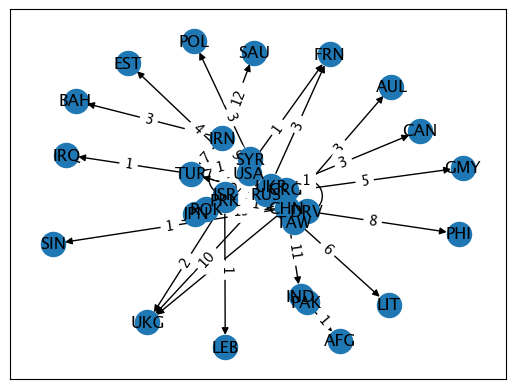

In [52]:

# Show the weights of the edges
pos=nx.spring_layout(G) 
nx.draw_networkx(G,pos)

# Todo: Avoid overlapping of the weight labels
# Todo: Avoid overlapping of the nodes
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [53]:
from pyvis.network import Network

net = Network(notebook=True, cdn_resources='in_line')
net.from_nx(G)
net.show("output/network.html")

# # Open the HTML file in the browser or
# # read from file to buffer
# with open("network.html", "r") as file:
#     network_html = file.read()

# HTML(network_html)

output/network.html


In [54]:
# Make the graph directed

net = Network(notebook=True, directed =True, cdn_resources='in_line')
net.from_nx(G)
net.show("output/network-directed.html")

# #read from file to buffer
# with open("network-directed.html", "r") as file:
#     network_html = file.read()

# HTML(network_html)

output/network-directed.html


# Network images
![](./output/network-weights.png)
![](./output/network-directed.png)

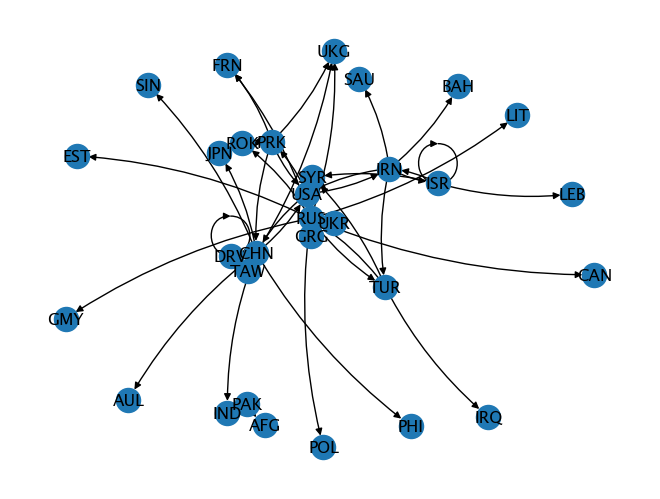

[('CHN', 'AUL', {'width': 1}), ('CHN', 'DRV', {'width': 1}), ('CHN', 'IND', {'width': 1}), ('CHN', 'JPN', {'width': 1}), ('CHN', 'PHI', {'width': 1}), ('CHN', 'SIN', {'width': 1}), ('CHN', 'TAW', {'width': 1}), ('CHN', 'UKG', {'width': 1}), ('CHN', 'USA', {'width': 1}), ('DRV', 'DRV', {'width': 1}), ('DRV', 'CHN', {'width': 1}), ('GRG', 'RUS', {'width': 1}), ('IND', 'PAK', {'width': 1}), ('IRN', 'BAH', {'width': 1}), ('IRN', 'ISR', {'width': 1}), ('IRN', 'SAU', {'width': 1}), ('IRN', 'TUR', {'width': 1}), ('IRN', 'USA', {'width': 1}), ('ISR', 'ISR', {'width': 1}), ('ISR', 'IRN', {'width': 1}), ('ISR', 'LEB', {'width': 1}), ('ISR', 'SYR', {'width': 1}), ('JPN', 'ROK', {'width': 1}), ('PAK', 'AFG', {'width': 1}), ('PAK', 'IND', {'width': 1}), ('PRK', 'CHN', {'width': 1}), ('PRK', 'FRN', {'width': 1}), ('PRK', 'JPN', {'width': 1}), ('PRK', 'ROK', {'width': 1}), ('PRK', 'UKG', {'width': 1}), ('PRK', 'USA', {'width': 1}), ('ROK', 'JPN', {'width': 1}), ('ROK', 'PRK', {'width': 1}), ('RUS', '

In [55]:
# Try curved edges
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, connectionstyle="arc3,rad=0.1")

labels = nx.get_edge_attributes(G,'weight')

# FIXME: place the labels in a better way
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, label_pos=0.1)
plt.show()

# show the datastructure of the graph
print(G.edges(data=True))


In [56]:
# Show the network on a map
# https://towardsdatascience.com/from-geojson-to-network-graph-analyzing-world-country-borders-in-python-ab81b5a8ce5a 

# TODO: rework this part

# import geopandas as gpd
# plt.rcParams['font.family'] = 'Arial'

# world_map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# world_map = world_map[world_map['continent'] != 'Antarctica']
# world_map.plot()
# plt.show() 

# world_map = world_map.set_index('iso_a3')

# # 1. Geocode the countries
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="dcid-sna")

# def geolocate(country):
#     loc = geolocator.geocode(country)
#     return (loc.latitude, loc.longitude)

# print(geolocate('USA'))

# 2. Add the latitude and longitude to the graph

# for node in G.nodes:
#     country = labels[node]
#     lat, lon = geolocate(country)
#     G.nodes[node]['latitude'] = lat
#     G.nodes[node]['longitude'] = lon
# node_positions = {n: (d['longitude'], d['latitude']) for n, d in G.nodes(data=True)}

# 3. Plot the network on the map



# Top Cyber Powers

![](./output/cyber-power-index.png)

National Cyber Power Index, Voo et al. (2022)

In [57]:
# Calculte some properties of the graph

# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html
# The degree centrality for a node v is the fraction of nodes it is connected to.
centrality = nx.degree_centrality(G)
centrality = pd.DataFrame(centrality.items(), columns=['Country', 'Centrality'])
centrality = centrality.sort_values(by='Centrality', ascending=False)
print(centrality)


   Country  Centrality
22     RUS    0.533333
4      CHN    0.433333
30     USA    0.300000
20     PRK    0.266667
11     IRN    0.233333
13     ISR    0.200000
21     ROK    0.166667
27     TUR    0.166667
5      DRV    0.133333
14     JPN    0.133333
25     SYR    0.100000
17     PAK    0.100000
28     UKG    0.100000
10     IND    0.100000
7      FRN    0.066667
26     TAW    0.066667
29     UKR    0.066667
9      GRG    0.066667
3      CAN    0.033333
2      BAH    0.033333
1      AUL    0.033333
6      EST    0.033333
0      AFG    0.033333
12     IRQ    0.033333
8      GMY    0.033333
16     LIT    0.033333
18     PHI    0.033333
19     POL    0.033333
15     LEB    0.033333
23     SAU    0.033333
24     SIN    0.033333


In [58]:
# Out Degree: https://networkx.org/documentation/stable/reference/classes/generated/networkx.DiGraph.out_degree.html
# The node out_degree is the number of edges pointing out of the node. 
out_degree = G.out_degree()
sorted_out_degree = sorted(out_degree, key=lambda x: x[1], reverse=True)
sorted_out_degree = pd.DataFrame(sorted_out_degree, columns=['Country', 'Out Degree'])
print(sorted_out_degree)

# Weighted out degree
# The weighted node degree is the sum of the edge weights for edges incident to that node.
weighted_out_degree = G.out_degree(weight='weight')
sorted_weighted_out_degree = sorted(weighted_out_degree, key=lambda x: x[1], reverse=True)
sorted_weighted_out_degree = pd.DataFrame(sorted_weighted_out_degree, columns=['Country', 'Weighted Out Degree'])
print(sorted_weighted_out_degree)

# FIXME: Out Degree sould not be the same as Weighted Out Degree

   Country  Out Degree
0      RUS          12
1      CHN           9
2      PRK           6
3      IRN           5
4      ISR           4
5      USA           4
6      TUR           3
7      DRV           2
8      PAK           2
9      ROK           2
10     GRG           1
11     IND           1
12     JPN           1
13     SYR           1
14     TAW           1
15     UKR           1
16     AFG           0
17     AUL           0
18     BAH           0
19     CAN           0
20     EST           0
21     FRN           0
22     GMY           0
23     IRQ           0
24     LEB           0
25     LIT           0
26     PHI           0
27     POL           0
28     SAU           0
29     SIN           0
30     UKG           0
   Country  Weighted Out Degree
0      RUS                   12
1      CHN                    9
2      PRK                    6
3      IRN                    5
4      ISR                    4
5      USA                    4
6      TUR                    3
7      D

In [59]:
# In Degree: https://networkx.org/documentation/stable/reference/classes/generated/networkx.DiGraph.in_degree.html
# The node in_degree is the number of edges pointing to the node. 
# Number of antagonsits attacking a country
in_degree = G.in_degree()
sorted_in_degree = sorted(in_degree, key=lambda x: x[1], reverse=True)
sorted_in_degree = pd.DataFrame(sorted_in_degree, columns=['Country', 'In Degree'])
print(sorted_in_degree)

# The weighted node degree is the sum of the edge weights for edges incident to that node.
weighted_in_degree = G.in_degree(weight='weight')
sorted_weighted_in_degree = sorted(weighted_in_degree, key=lambda x: x[1], reverse=True)
sorted_weighted_in_degree = pd.DataFrame(sorted_weighted_in_degree, columns=['Country', 'Weighted In Degree'])
print(sorted_weighted_in_degree)

# FIXME: The two tables shouldn't be the same

   Country  In Degree
0      USA          5
1      CHN          4
2      RUS          4
3      JPN          3
4      ROK          3
5      UKG          3
6      DRV          2
7      FRN          2
8      IND          2
9      IRN          2
10     ISR          2
11     PRK          2
12     SYR          2
13     TUR          2
14     AFG          1
15     AUL          1
16     BAH          1
17     CAN          1
18     EST          1
19     GMY          1
20     GRG          1
21     IRQ          1
22     LEB          1
23     LIT          1
24     PAK          1
25     PHI          1
26     POL          1
27     SAU          1
28     SIN          1
29     TAW          1
30     UKR          1
   Country  Weighted In Degree
0      USA                   5
1      CHN                   4
2      RUS                   4
3      JPN                   3
4      ROK                   3
5      UKG                   3
6      DRV                   2
7      FRN                   2
8      IND       

In [60]:
# Reciprocity: https://networkx.org/documentation/stable/reference/algorithms/reciprocity.html
# The reciprocity of a directed graph is the ratio of the number of edges pointing in both directions
# to the total number of edges in the graph.

reciprocity = nx.overall_reciprocity(G)
print(reciprocity)


0.4727272727272727


In [61]:
# Cliques: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.clique.find_cliques.html
# A clique in an undirected graph is a subset of the nodes such that every two nodes in the subset are adjacent.

# cliques = nx.find_cliques(G)
# Only works for an undirected graph

# Conclusion

Preparing and reshaping the data took longest. I was struggling with messy data (Excel with multiple working sheets) and merging data to get country codes. Additionally, drawing my particular graph, including the labels on the edges, proved to be more difficult than expected. The graph would look great on a spatial map, but geo-coding the data will take more time.


Creating the adjacency matrix for my dataset was easy. Running network analysis and calculating statistics such as degree centrality or reciprocity is super easy after you create the graph.

Network analysis is an interesting method, and I'll use it in my research one way or another.
